## Hydrolgical output 

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults
# plot defaults
import os
import xarray as xr
import numpy as np
import pandas as pd
#import salem


import oggm.cfg
from oggm import  utils, workflow, tasks, graphics
import geopandas as gpd
import json
from oggm.shop import gcm_climate


In [9]:
basin = 'INDUS'

# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='Hydro-Output')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is when ice thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True
# Hintereisferner

pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
rgi_id = rgis_basin[1000]
# We pick the elevation-bands glaciers because they run a bit faster - but they create more step changes in the area outputs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=160, prepro_base_url=base_url)[0]


2023-03-14 11:57:23: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-14 11:57:23: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-14 11:57:23: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-03-14 11:57:23: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2023-03-14 11:57:23: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2023-03-14 11:57:23: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2023-03-14 11:57:23: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


basically reproducing `test_hydro_dynamical_spinup` from `test_models` : 

In [10]:
ALL_DIAGS = ['volume', 'volume_bsl', 'volume_bwl', 'area', 'length',
             'off_area', 'on_area', 'melt_off_glacier',
             'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',
             'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb',
             'residual_mb', 'snow_bucket']
# Add debug vars
oggm.cfg.PARAMS['store_diagnostic_variables'] = ALL_DIAGS
# Needed for this to run
oggm.cfg.PARAMS['store_model_geometry'] = True

2023-03-14 11:57:24: oggm.cfg: PARAMS['store_diagnostic_variables'] changed from `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier']` to `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb', 'residual_mb', 'snow_bucket']`.


In [11]:
 climate_input_filesuffix='_' + rid,  # use a different scenario


In [12]:
gcms = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)


In [13]:
gdirs = [gdir]

In [15]:
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)

for gcm in gcms_cmip6.gcm.unique()[:1]: ##TEST:
    df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm]
    for ssp in df1.ssp.unique():
        df2 = df1.loc[df1.ssp == ssp]
        assert len(df2) == 2
        ft = df2.loc[df2['var'] == 'tas'].iloc[0]
        fp = df2.loc[df2['var'] == 'pr'].iloc[0].path
        rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
        rid='_CMIP6_' + rid
        ft = ft.path

        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                     filesuffix=rid,  # recognize the climate file for later
                                     fpath_temp=ft,  # temperature projections
                                     fpath_precip=fp,  # precip projections
                                     #year_range=('1981', '2018'),
                                     );

2023-03-14 11:57:48: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-03-14 11:57:49: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-03-14 11:57:50: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-03-14 11:57:51: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-03-14 11:58:02: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers


In [17]:
xr.open_dataset(gdir.get_filepath('gcm_data', filesuffix=rid))

<xarray.Dataset>
Dimensions:  (time: 3012)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-14 ... 2100-12-15
Data variables:
    prcp     (time) float32 ...
    temp     (time) float32 ...
Attributes:
    ref_hgt:         4990.0
    ref_pix_lon:     80.0
    ref_pix_lat:     34.3979057591623
    ref_pix_dis:     47360.00650275209
    climate_source:  _CMIP6_CESM2-WACCM_ssp245
    yr_0:            1850
    yr_1:            2100
    author:          OGGM
    author_info:     Open Global Glacier Model

In [37]:
import logging
# Module logger
log = logging.getLogger(__name__)
from oggm import entity_task
@entity_task(log)
def run_hydro_from_2000_ref_area_2000(gdir):
    '''Runs historical hydro climate from 2000 until 2020. 
    Finally the future projections for the three SSPs by using ISIMIP3b. The ref_area_yr is 2000.
    
    '''

    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                         climate_filename='climate_historical',
                         ys=2000, init_model_yr=2000,
                         store_monthly_hydro=True,
                         init_model_filesuffix='_spinup_historical',
                         ref_geometry_filesuffix='_spinup_historical',
                         ref_area_yr = 2000,
                         output_filesuffix='_historical_from_2000_run')

    
    
    ### ISIMPI3b
    members = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
           'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ]
    # only this part needs to be recomputed for every member and ssp...
    for member in members:
        for ssp in ['ssp126', 'ssp370', 'ssp585']:
            rid = f'_ISIMIP3b_{member}_{ssp}'
            tasks.run_with_hydro(gdir,
                                 run_task=tasks.run_from_climate_data, ys=2020, # this is important! Start from 2020 glacier
                                 # use gcm_data, not climate_historical
                                 climate_filename='gcm_data',
                                 # use the chosen scenario
                                 climate_input_filesuffix=rid,
                                 # we start from the previous run, 
                                 init_model_filesuffix='_historical_from_2000_run',
                                 ref_geometry_filesuffix='_historical_from_2000_run', 
                                 ref_area_yr = 2000,
                                 # recognize the run for later
                                 output_filesuffix=f'_future_run{rid}',
                                 # add monthly diagnostics
                                 store_monthly_hydro=True);
            

            utils.merge_consecutive_run_outputs(gdir,
                                                input_filesuffix_1='_historical_from_2000_run',
                                                input_filesuffix_2=f'_future_run{rid}',
                                                output_filesuffix=f'_merged_from_2000_run{rid}',
                                                delete_input=False,
                                               ) # we will delete that later
    
    
    ### CMIP6 
    gcms = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
    
    for gcm in gcms.gcm.unique():
        df1 = gcms.loc[gcms.gcm == gcm]
        for ssp in df1.ssp.unique():
            df2 = df1.loc[df1.ssp == ssp]
            assert len(df2) == 2
            ft = df2.loc[df2['var'] == 'tas'].iloc[0]
            rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
            rid2='_CMIP6_' + rid
            
            tasks.run_with_hydro(gdir,
                     run_task=tasks.run_from_climate_data,
                                 ys=2020, # this is important! Start from 2020 glacier
                     # use gcm_data, not climate_historical
                     climate_filename='gcm_data',
                     # use the chosen scenario
                     climate_input_filesuffix='_'+rid,
                     # we start from the previous run, 
                     init_model_filesuffix='_historical_from_2000_run',
                     ref_geometry_filesuffix='_historical_from_2000_run', 
                     ref_area_yr = 2000,
                     # recognize the run for later
                     output_filesuffix=f'_future_run{rid2}',
                     # add monthly diagnostics
                     store_monthly_hydro=True);
            
            
            utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_historical_from_2000_run',
                                    input_filesuffix_2=f'_future_run{rid2}',
                                    output_filesuffix=f'_merged_from_2000_run{rid2}',
                                    delete_input=False,
                                   ) # we will delete that later
            
# from func_add import run_hydro_from_2000_ref_area_2000

In [30]:
# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
from oggm.shop import gcm_climate
#member = 'mri-esm2-0_r1i1p1f1' 
members = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
           'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ]
for member in members:
    # Download the three main SSPs
    for ssp in ['ssp126', 'ssp370','ssp585']:
        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, [gdir], 
                                     ssp = ssp,
                                     # gcm member -> you can choose another one
                                     member=member,
                                     # recognize the climate file for later
                                     output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                     );

2023-03-14 10:41:20: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:21: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:22: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:23: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:24: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:24: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:25: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:26: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:26: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-14 10:41:27: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1

In [39]:
ls /tmp/OGGM/Hydro-Output/per_glacier/RGI60-13/RGI60-13.52/RGI60-13.52509

climate_historical.nc
dem.tif
dem_source.txt
diagnostics.json
downstream_line.pkl
elevation_band_flowline.csv
gcm_data_BCC-CSM2-MR_ssp126.nc
gcm_data_BCC-CSM2-MR_ssp245.nc
gcm_data_BCC-CSM2-MR_ssp370.nc
gcm_data_BCC-CSM2-MR_ssp585.nc
gcm_data_CAMS-CSM1-0_ssp119.nc
gcm_data_CAMS-CSM1-0_ssp126.nc
gcm_data_CAMS-CSM1-0_ssp245.nc
gcm_data_CAMS-CSM1-0_ssp370.nc
gcm_data_CAMS-CSM1-0_ssp585.nc
gcm_data_CESM2-WACCM_ssp126.nc
gcm_data_CESM2-WACCM_ssp245.nc
gcm_data_CESM2-WACCM_ssp370.nc
gcm_data_CESM2-WACCM_ssp534-over.nc
gcm_data_CESM2-WACCM_ssp585.nc
gcm_data_CESM2_ssp126.nc
gcm_data_CESM2_ssp245.nc
gcm_data_CESM2_ssp370.nc
gcm_data_CESM2_ssp585.nc
gcm_data_CMCC-CM2-SR5_ssp245.nc
gcm_data_CMCC-CM2-SR5_ssp585.nc
gcm_data_EC-Earth3-Veg_ssp119.nc
gcm_data_EC-Earth3-Veg_ssp126.nc
gcm_data_EC-Earth3-Veg_ssp245.nc
gcm_data_EC-Earth3-Veg_ssp370.nc
gcm_data_EC-Earth3-Veg_ssp585.nc
gcm_data_EC-Earth3_ssp126.nc
gcm_data_EC-Earth3_ssp245.nc
gcm_data_EC-Earth3_ssp370.nc
gcm_data_EC-Earth3_ssp585.nc
gcm_da

In [38]:
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000, gdirs)


2023-03-14 10:44:38: oggm.workflow: Execute entity tasks [run_hydro_from_2000_ref_area_2000] on 1 glaciers


[None]

In [ ]:
model_diagnostics_merged_from_2000_run_CMIP6_BCC-CSM2-MR_ssp126.nc

In [32]:
dt.close()

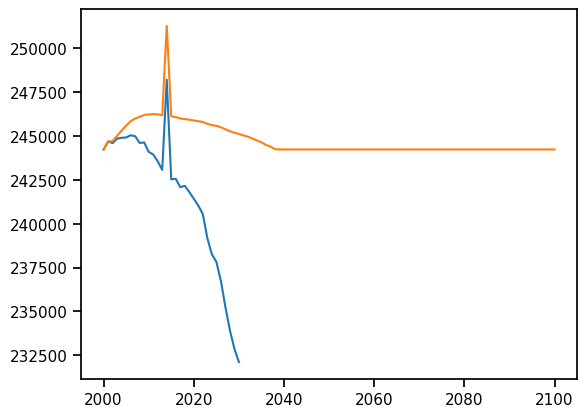

In [15]:
rid = f'_ISIMIP3b_{member}_{ssp}'
dt = xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=f'_merged_from_2000_run{rid}'))
plt.plot(dt.time.sel(time=slice(1980,2030)), dt.area_m2.sel(time=slice(1980,2030)), label=f'_merged_from_2000_run{rid}')
plt.plot(dt.time, dt['on_area'] + dt['off_area'])

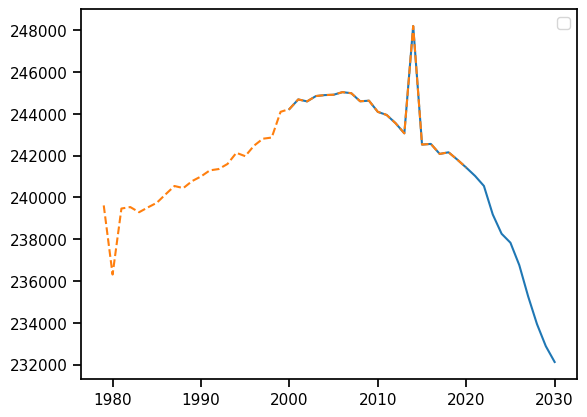

In [98]:
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     climate_filename='climate_historical',
                     ys=2000, init_model_yr=2000,m
                     store_monthly_hydro=True,
                     init_model_filesuffix='_spinup_historical',
                     ref_geometry_filesuffix='_spinup_historical',
                     ref_area_yr = 2000,
                     output_filesuffix='_historical_from_2000_run')

tasks.run_with_hydro(gdir,
                     run_task=tasks.run_from_climate_data, ys=2020, # this is important! Start from 2020 glacier
                     # use gcm_data, not climate_historical
                     climate_filename='gcm_data',
                     # use the chosen scenario
                     climate_input_filesuffix=rid,
                     # we start from the previous run, 
                     init_model_filesuffix='_historical_from_2000_run',
                     ref_geometry_filesuffix='_historical_from_2000_run', 
                     ref_area_yr = 2000,
                     # recognize the run for later
                     output_filesuffix=f'_future_run{rid}',
                     # add monthly diagnostics
                     store_monthly_hydro=True);

dt = utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_historical_from_2000_run',
                                    input_filesuffix_2=f'_future_run{rid}',
                                    output_filesuffix=f'_merged_from_2000_run{rid}',
                                    delete_input=False,
                                   ) # we will delete that later

dspinup = xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_historical'))
plt.plot(dt.time.sel(time=slice(1980,2030)), dt.area_m2.sel(time=slice(1980,2030)), label=f'_merged_from_2000_run{rid}')
plt.plot(dspinup.time, dspinup.area_m2, ls= '--', label='_spinup_historical')


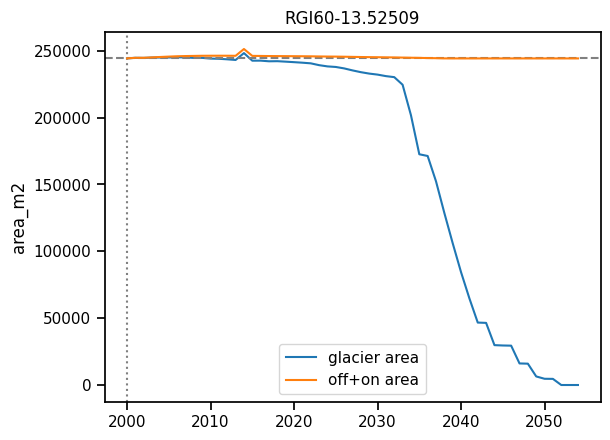

In [100]:
# graphical test:
ds = xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                               filesuffix=f'_merged_from_2000_run{rid}'))
ds_t = ds.mean(dim='month_2d').isel(time=slice(0,55))




plt.plot(ds_t.time, ds_t.area_m2, label='glacier area')
plt.axhline(ds_t.area_m2.sel(time=2000), ls='--', color = 'grey')
plt.axvline(2000, ls=':', color='grey')
plt.plot(ds_t.time, ds_t['off_area'] + ds_t['on_area'], label='off+on area')
plt.ylabel('area_m2')
plt.title(gdir.rgi_id)
plt.legend()

np.testing.assert_allclose(gdir.rgi_area_m2, 
                           ds_t.area_m2.sel(time=gdir.rgi_date+1),
                          rtol=1e-2)


In [99]:
dt = utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_spinup_historical',
                                    input_filesuffix_2=f'_historical_from_rgi_date_run',
                                    output_filesuffix=f'_test',
                                    delete_input=False,
                                   ) 

2023-03-14 09:50:09: oggm.utils: InvalidWorkflowError occurred during task merge_consecutive_run_outputs_test on RGI60-13.52509: The two files are incompatible by time


InvalidWorkflowError: The two files are incompatible by time

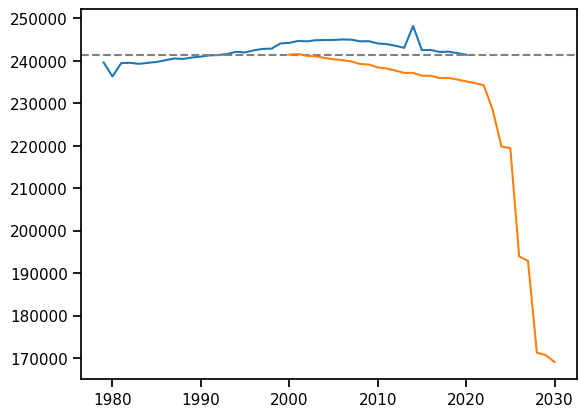

In [85]:
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     climate_filename='climate_historical',
                     ys=2000, 
                     store_monthly_hydro=True,
                     init_model_filesuffix='_spinup_historical',
                     ref_geometry_filesuffix='_spinup_historical',
                     ref_area_yr = 2000,
                     output_filesuffix='_historical_from_rgi_date_run')

tasks.run_with_hydro(gdir,
                     run_task=tasks.run_from_climate_data, ys=2020, # this is important! Start from 2020 glacier
                     # use gcm_data, not climate_historical
                     climate_filename='gcm_data',
                     # use the chosen scenario
                     climate_input_filesuffix=rid,
                     # we start from the previous run, 
                     init_model_filesuffix='_historical_from_rgi_date_run',
                     ref_geometry_filesuffix='_historical_from_rgi_date_run', 
                     ref_area_yr = 2000,
                     # recognize the run for later
                     output_filesuffix=f'_future_run{rid}_{member}',
                     # add monthly diagnostics
                     store_monthly_hydro=True);


dt = utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_historical_from_rgi_date_run',
                                    input_filesuffix_2=f'_future_run{rid}_{member}',
                                    output_filesuffix=f'_merged',
                                    delete_input=False,
                                   ) # we will delete that later

dspinup = xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_historical'))
plt.plot(dspinup.time, dspinup.area_m2)
plt.axhline(dspinup.area_m2.sel(time=2020), color='grey', ls='--')
plt.plot(dt.time.sel(time=slice(1980,2030)), dt.area_m2.sel(time=slice(1980,2030)))


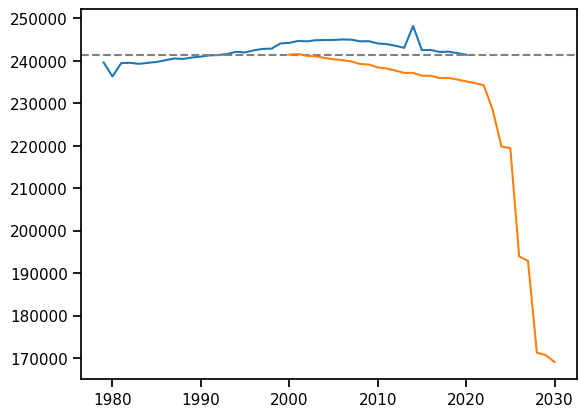

In [24]:
# if gdir.rgi_date is before 2000???
#gdir.rgi_date = 1995 --> it still works

In [63]:
ls /tmp/OGGM/Hydro-Output/per_glacier/RGI60-13/RGI60-13.52/RGI60-13.52509

climate_historical.nc
dem.tif
dem_source.txt
diagnostics.json
downstream_line.pkl
elevation_band_flowline.csv
gcm_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126.nc
gcm_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp370.nc
gcm_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp585.nc
glacier_grid.json
gridded_data.nc
inversion_flowlines.pkl
inversion_input.pkl
inversion_output.pkl
log.txt
mb_calib.json
model_diagnostics_historical.nc
model_diagnostics_spinup_historical.nc
model_flowlines.pkl
model_flowlines_dyn_melt_f_calib.pkl
model_geometry_historical.nc
model_geometry_spinup_historical.nc
outlines.tar.gz


In [ ]:
# Merges data from preprocessing tasks. First task after inversion! --> this has actually already been done in level 4
#oggm.core.flowline.init_present_time_glacier(gdir)

# increasing ye until 2000 increases the runtime but probably there are not so many glaciers
# with rgi_date <2000, we need to go until 2000, as this is the reference year (also for the spinup!!!)
# default: ye = gdir.rgi_date + 1
# ye has to be 2001 or later, if  (gdir.rgi_date + 1)> 2001
ye=2001 if (gdir.rgi_date + 1)<2001 else gdir.rgi_date + 1

# `run_with_hydro` with run_dyanmic spinup wants to go until rgi date, so we just let it go until then
#  in case of HEF, it goes until 2004 (however, hydro stuff only until 2003)
tasks.run_with_hydro(gdir, run_task=tasks.run_dynamic_spinup,
                     store_monthly_hydro=True,
                     ye=ye,
                     # this is important
                     ref_area_yr = 2000,
                     output_filesuffix='_spinup_rgi_date')

# start from rgi date (this happens automatically), in case of HEF, this is 2004
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     climate_filename='climate_historical',
                     ys=ye, 
                     store_monthly_hydro=True,
                     init_model_filesuffix='model_geometry_spinup_historical',
                     ref_geometry_filesuffix='model_geometry_spinup_historical',
                     ref_area_yr = 2000,
                     output_filesuffix='_historical_from_rgi_date_run')


utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_spinup_rgi_date',
                                    input_filesuffix_2='_historical_from_rgi_date_run',
                                    output_filesuffix=f'_hist_w_spinup_run',
                                    delete_input=True,
                                   ) # we will delete that later

for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_with_hydro, [gdir],
                             run_task=tasks.run_from_climate_data, ys=2020, # this is important! Start from 2020 glacier
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # we start from the previous run, 
                             init_model_filesuffix='_historical_from_rgi_date_run',
                             # howver, the ref_geometry comes from the first run,
                             # this is dfifferent to init_model_filesuffix as we want to copy the reference area from the spinup (as here the gdir is after ref_area_yr)
                                 # if gdir is before ref_area_yr --> nedd to change that probably??? 
                             ref_geometry_filesuffix='_spinup_rgi_date', 
                             ref_area_yr = 2000,
                             # recognize the run for later
                             output_filesuffix=f'_future_run{rid}',
                             # add monthly diagnostics
                             store_monthly_hydro=True);

    #this is a bit stupid, but there is no input_filesuffix_3, as far as I can see:
    utils.merge_consecutive_run_outputs(gdir,
                                        input_filesuffix_1='_hist_w_spinup_run',
                                        input_filesuffix_2=f'_future_run{rid}',
                                        output_filesuffix=f'_merged_{member}_{ssp}')
    os.remove(gdir.get_filepath('model_diagnostics', filesuffix=f'_future_run{rid}'))
    # we did not delete the input here because we need _hist_w_spinup_run for all the ssps
# we just remove the hist_w_spinup_run at the end 
os.remove(gdir.get_filepath('model_diagnostics', filesuffix='_hist_w_spinup_run'))

In [25]:
gdir.rgi_date

2002

In [36]:
# Merges data from preprocessing tasks. First task after inversion! --> this has actually already been done in level 4
#oggm.core.flowline.init_present_time_glacier(gdir)

# increasing ye until 2000 increases the runtime but probably there are not so many glaciers
# with rgi_date <2000, we need to go until 2000, as this is the reference year (also for the spinup!!!)
# default: ye = gdir.rgi_date + 1
# ye has to be 2001 or later, if  (gdir.rgi_date + 1)> 2001
ye=2001 if (gdir.rgi_date + 1)<2001 else gdir.rgi_date + 1

# `run_with_hydro` with run_dyanmic spinup wants to go until rgi date, so we just let it go until then
#  in case of HEF, it goes until 2004 (however, hydro stuff only until 2003)
tasks.run_with_hydro(gdir, run_task=tasks.run_dynamic_spinup,
                     store_monthly_hydro=True,
                     ye=ye,
                     # this is important
                     ref_area_yr = 2000,
                     output_filesuffix='_spinup_rgi_date')

# start from rgi date (this happens automatically), in case of HEF, this is 2004
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     climate_filename='climate_historical',
                     ys=ye, 
                     store_monthly_hydro=True,
                     init_model_filesuffix='_spinup_rgi_date',
                     ref_geometry_filesuffix='_spinup_rgi_date',
                     ref_area_yr = 2000,
                     output_filesuffix='_historical_from_rgi_date_run')


utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_spinup_rgi_date',
                                    input_filesuffix_2='_historical_from_rgi_date_run',
                                    output_filesuffix=f'_hist_w_spinup_run',
                                    delete_input=True,
                                   ) # we will delete that later

for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_with_hydro, [gdir],
                             run_task=tasks.run_from_climate_data, ys=2020, # this is important! Start from 2020 glacier
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # we start from the previous run, 
                             init_model_filesuffix='_historical_from_rgi_date_run',
                             # howver, the ref_geometry comes from the first run,
                             # this is dfifferent to init_model_filesuffix as we want to copy the reference area from the spinup (as here the gdir is after ref_area_yr)
                                 # if gdir is before ref_area_yr --> nedd to change that probably??? 
                             ref_geometry_filesuffix='_spinup_rgi_date', 
                             ref_area_yr = 2000,
                             # recognize the run for later
                             output_filesuffix=f'_future_run{rid}',
                             # add monthly diagnostics
                             store_monthly_hydro=True);

    #this is a bit stupid, but there is no input_filesuffix_3, as far as I can see:
    utils.merge_consecutive_run_outputs(gdir,
                                        input_filesuffix_1='_hist_w_spinup_run',
                                        input_filesuffix_2=f'_future_run{rid}',
                                        output_filesuffix=f'_merged_{member}_{ssp}')
    os.remove(gdir.get_filepath('model_diagnostics', filesuffix=f'_future_run{rid}'))
    # we did not delete the input here because we need _hist_w_spinup_run for all the ssps
# we just remove the hist_w_spinup_run at the end 
os.remove(gdir.get_filepath('model_diagnostics', filesuffix='_hist_w_spinup_run'))

2023-03-13 23:46:03: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-03-13 23:46:04: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-03-13 23:46:04: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers


In [27]:
gdirs = [gdir]

In [28]:
# some tests 
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_merged_{member}_{ssp}'
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()
        
        # Domain area is constant and equal to the ref_area_yr
        # at least in the time period 2000 and later
        # during spinup it is ok, that the domain area is different?!
        np.testing.assert_allclose(ds.area_m2.sel(time=2000),
                           (ds['off_area'] + ds['on_area']).sel(time=slice(2000,2100)), rtol=0.001)
    
    
    # let's do similar tests as in `test_hydro_dynamical_spinup` (some had to be adapted)
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                               filesuffix=file_id)) as ds:
        sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
        odf = ds[sel_vars].to_dataframe().iloc[:-1]
        

        # Sanity checks
        odf['tot_prcp'] = (odf['liq_prcp_off_glacier'] +
                           odf['liq_prcp_on_glacier'] +
                           odf['snowfall_off_glacier'] +
                           odf['snowfall_on_glacier'])

        # Glacier area is the same (remove on_area?)
        np.testing.assert_allclose(odf['on_area'], odf['area_m2'])

        # Our MB is the same as the glacier dyn one
        reconstructed_vol = (odf['model_mb'].cumsum() / oggm.cfg.PARAMS['ice_density'] +
                             odf['volume_m3'].iloc[0])
        
        np.testing.assert_allclose(odf['volume_m3'].iloc[1:],
                                   reconstructed_vol.iloc[:-1], atol=1e-6) ### Had to add here atol=1e-6 --> IS THAT OK?????? TO CHECK Fabi,Patrick

        # Ensure mass-conservation even at junction?
        odf['runoff'] = (odf['melt_on_glacier'] +
                         odf['melt_off_glacier'] +
                         odf['liq_prcp_on_glacier'] +
                         odf['liq_prcp_off_glacier'])

        mass_in_glacier_end = odf['volume_m3'].iloc[-1] * oggm.cfg.PARAMS['ice_density']
        mass_in_glacier_start = odf['volume_m3'].iloc[0] * oggm.cfg.PARAMS['ice_density']

        mass_in_snow = odf['snow_bucket'].iloc[-1]
        mass_in = odf['tot_prcp'].iloc[:-1].sum()
        mass_out = odf['runoff'].iloc[:-1].sum()
        np.testing.assert_allclose(mass_in_glacier_end,
                        mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                        atol=1e-2)  # 0.01 kg is OK as numerical error

        # Residual MB should not be crazy large
        frac = odf.loc[:2025]['residual_mb'] / odf.loc[:2025]['melt_on_glacier']
        np.testing.assert_allclose(frac, 0,atol=0.05) ### I just use here the historical projections, as afterwards melt_on_glacier gets very small or even zero


AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatched elements: 66 / 101 (65.3%)
Max absolute difference: 25976.64675938
Max relative difference: 0.01746218
 x: array(1461618.371107)
 y: array([1461618.371107, 1462078.286807, 1462435.866115, 1462902.656528,
       1463631.71982 , 1464273.345757, 1465120.602845, 1465898.66687 ,
       1470412.763756, 1471085.084931, 1471618.787709, 1472513.501672,...

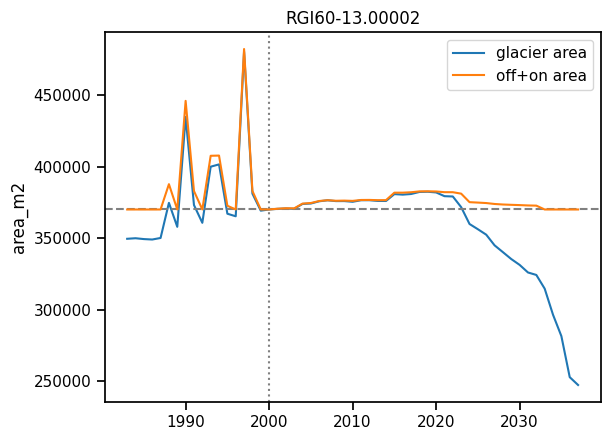

In [40]:
# graphical test:
ds = xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                               filesuffix=file_id))
ds_t = ds.mean(dim='month_2d').isel(time=slice(0,55))




plt.plot(ds_t.time, ds_t.area_m2, label='glacier area')
plt.axhline(ds_t.area_m2.sel(time=2000), ls='--', color = 'grey')
plt.axvline(2000, ls=':', color='grey')
plt.plot(ds_t.time, ds_t['off_area'] + ds_t['on_area'], label='off+on area')
plt.ylabel('area_m2')
plt.title(gdir.rgi_id)
plt.legend()

np.testing.assert_allclose(gdir.rgi_area_m2, 
                           ds_t.area_m2.sel(time=gdir.rgi_date+1),
                          rtol=1e-2)


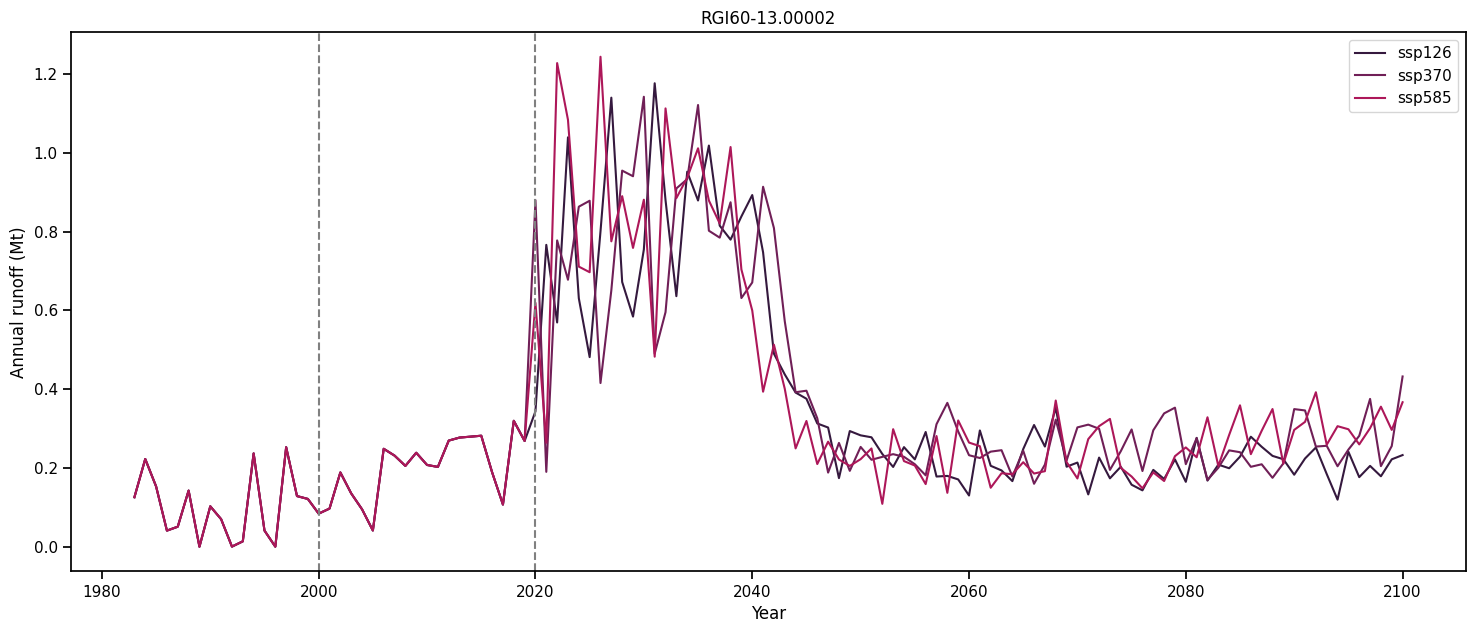

In [39]:
gdirs = [gdir]
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_merged_{member}_{ssp}'
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1) #.rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[0].rgi_id); plt.legend();
ax.axvline(2000, c='grey', ls='--')
ax.axvline(2020, c='grey', ls='--')

IndexError: list index out of range

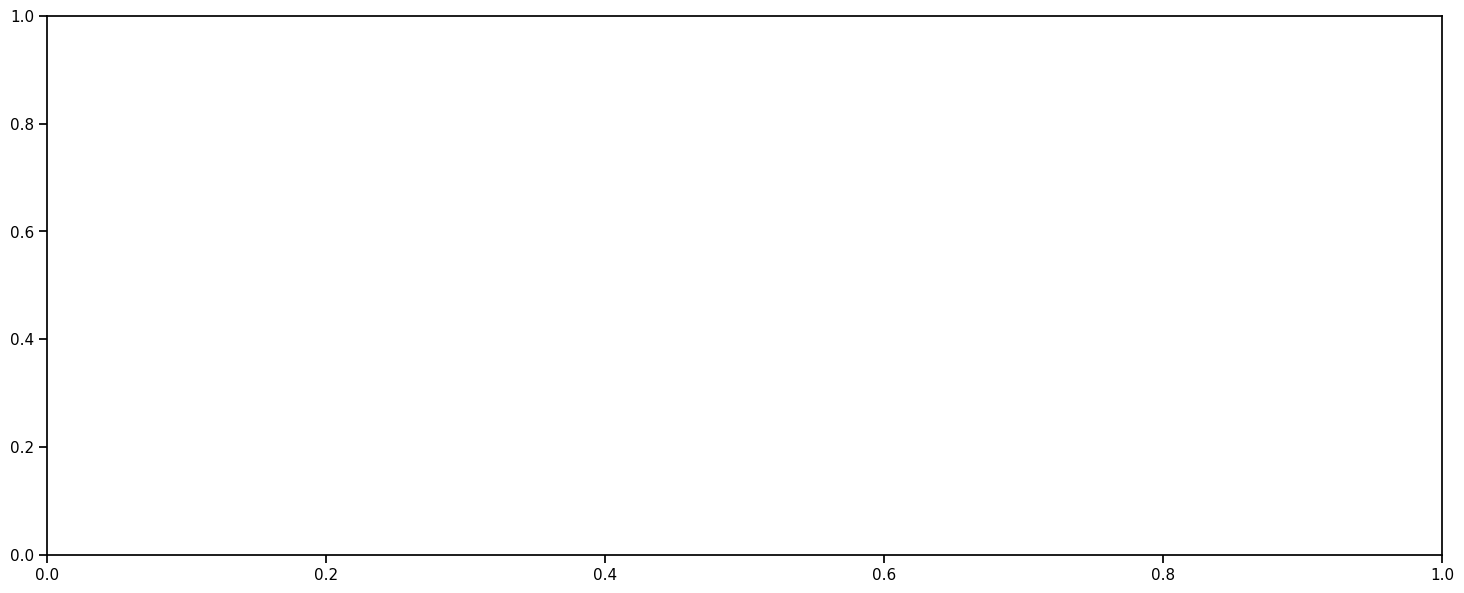

In [67]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_ISIMIP3b_{member}_{ssp}'
    # Open the data, gdirs[1] correspond to the unnamed glacier.
    with xr.open_dataset(gdirs[1].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
                   'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1).rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[1].rgi_id); plt.legend();

In [72]:
gdir.rgi_date = 1990


# Merges data from preprocessing tasks. First task after inversion! --> this has actually already been done 
#oggm.core.flowline.init_present_time_glacier(gdir)
tasks.run_with_hydro(gdir, run_task=tasks.run_dynamic_spinup,
                     store_monthly_hydro=True,
                     ref_area_from_y0=True,
                     output_filesuffix='_spinup')
tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                     store_monthly_hydro=True,
                     init_model_filesuffix='_spinup',
                     ref_geometry_filesuffix='_spinup',
                     ref_area_from_y0=True,
                     output_filesuffix='_run')

utils.merge_consecutive_run_outputs(gdir,
                                    input_filesuffix_1='_spinup',
                                    input_filesuffix_2='_run',
                                    output_filesuffix='_merged')

with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_merged')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf = ds[sel_vars].to_dataframe().iloc[:-1]

# Domain area is constant and equal to the first year
odf['dom_area'] = odf['on_area'] + odf['off_area']

# Sanity checks
odf['tot_prcp'] = (odf['liq_prcp_off_glacier'] +
                   odf['liq_prcp_on_glacier'] +
                   odf['snowfall_off_glacier'] +
                   odf['snowfall_on_glacier'])

# Glacier area is the same (remove on_area?)
np.testing.assert_allclose(odf['on_area'], odf['area_m2'])

# Our MB is the same as the glacier dyn one
reconstructed_vol = (odf['model_mb'].cumsum() / oggm.cfg.PARAMS['ice_density'] +
                     odf['volume_m3'].iloc[0])
np.testing.assert_allclose(odf['volume_m3'].iloc[1:], reconstructed_vol.iloc[:-1])

# Ensure mass-conservation even at junction?
odf['runoff'] = (odf['melt_on_glacier'] +
                 odf['melt_off_glacier'] +
                 odf['liq_prcp_on_glacier'] +
                 odf['liq_prcp_off_glacier'])

mass_in_glacier_end = odf['volume_m3'].iloc[-1] * oggm.cfg.PARAMS['ice_density']
mass_in_glacier_start = odf['volume_m3'].iloc[0] * oggm.cfg.PARAMS['ice_density']

mass_in_snow = odf['snow_bucket'].iloc[-1]
mass_in = odf['tot_prcp'].iloc[:-1].sum()
mass_out = odf['runoff'].iloc[:-1].sum()
np.testing.assert_allclose(mass_in_glacier_end,
                mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                atol=1e-2)  # 0.01 kg is OK as numerical error

# Residual MB should not be crazy large
frac = odf['residual_mb'] / odf['melt_on_glacier']
np.testing.assert_allclose(frac, 0, atol=0.05)


In [68]:
dt = xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_spinup'))
dt = dt.mean(dim='month_2d')
dt.on_area

<xarray.DataArray 'on_area' (time: 21)>
array([8015714.15500146, 8011578.24376412, 8017647.60153363,
       8010731.7024023 , 8015825.919777  , 8012836.23884206,
       8014953.16625611, 8022059.68247877, 8034096.9202996 ,
       8046757.8454764 , 8053571.78860588, 8063118.42108614,
       8052348.94852111, 8050781.45918081, 8074252.94931578,
       8054117.5527618 , 8048465.06172318, 8059856.68968856,
       8037349.7224276 , 8035549.1541752 ,              nan])
Coordinates:
  * time            (time) float64 1.971e+03 1.972e+03 ... 1.99e+03 1.991e+03
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...

In [73]:
dt = xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_run'))
dt = dt.mean(dim='month_2d')
dt.on_area

<xarray.DataArray 'on_area' (time: 30)>
array([8028855.16759111, 8017914.26542113, 8009121.80032088,
       8005518.94527226, 7987577.00076178, 7981245.05635925,
       7983898.08902503, 7969101.82319226, 7953427.4673879 ,
       7938178.40513716, 7928046.99570896, 7913192.57793649,
       7907097.75799859, 7873916.78812863, 7855097.80503963,
       7831543.51121857, 7801803.41489326, 7783307.23815488,
       7768512.81525611, 7718798.51954128, 7706645.38576737,
       7677479.02772163, 7651209.16455898, 7597984.42108603,
       7583113.38366492, 7553082.48138176, 7492167.53128947,
       7464455.40522677, 7429980.82586524,              nan])
Coordinates:
  * time            (time) float64 1.991e+03 1.992e+03 ... 2.019e+03 2.02e+03
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...

## adaptations ...

2023-03-13 20:04:46: oggm.utils: InvalidWorkflowError occurred during task merge_consecutive_run_outputs_test on RGI60-11.00897: The two files are incompatible by time


InvalidWorkflowError: The two files are incompatible by time

In [109]:
xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_test')).melt_on_glacier/1e9

<xarray.DataArray 'melt_on_glacier' (time: 50)>
array([16.56589389, 10.67374422, 18.14344335, 13.08253384, 16.53628857,
       12.62456883, 12.77765654,  9.38858097, 13.33299606, 13.13858336,
       14.57293606, 21.02635959, 21.54511012, 12.2355469 , 18.50763744,
       18.12500985, 17.79063724, 18.11329208, 15.28526056, 18.06755237,
       20.98401562, 22.35958783, 17.17651636, 23.07393229, 17.5745483 ,
       13.66284662, 18.69239826, 20.20677358, 21.41659898, 20.75046685,
       20.4123068 , 19.66046209, 28.34876708, 19.62587396, 20.60311926,
       24.65449642, 18.14380809, 19.06461643, 23.20106356, 18.06402152,
       22.08431303, 23.66864078, 21.14099008, 17.5561332 , 25.06390792,
       21.95059516, 23.67739039, 28.32016221, 25.47546248,         nan])
Coordinates:
  * time            (time) float64 1.971e+03 1.972e+03 ... 2.019e+03 2.02e+03
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...

In [113]:
(xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=f'_merged_{member}_{ssp}')).melt_on_glacier/1e9).sel(time=slice(2010,2020))

<xarray.DataArray 'melt_on_glacier' (time: 11)>
array([18.06402152, 22.08431303, 23.66864078, 21.14099008, 17.5561332 ,
       25.06390792, 21.95059516, 23.67739039, 28.32016221, 25.47546248,
       23.37477389])
Coordinates:
  * time            (time) float64 2.01e+03 2.011e+03 ... 2.019e+03 2.02e+03
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...

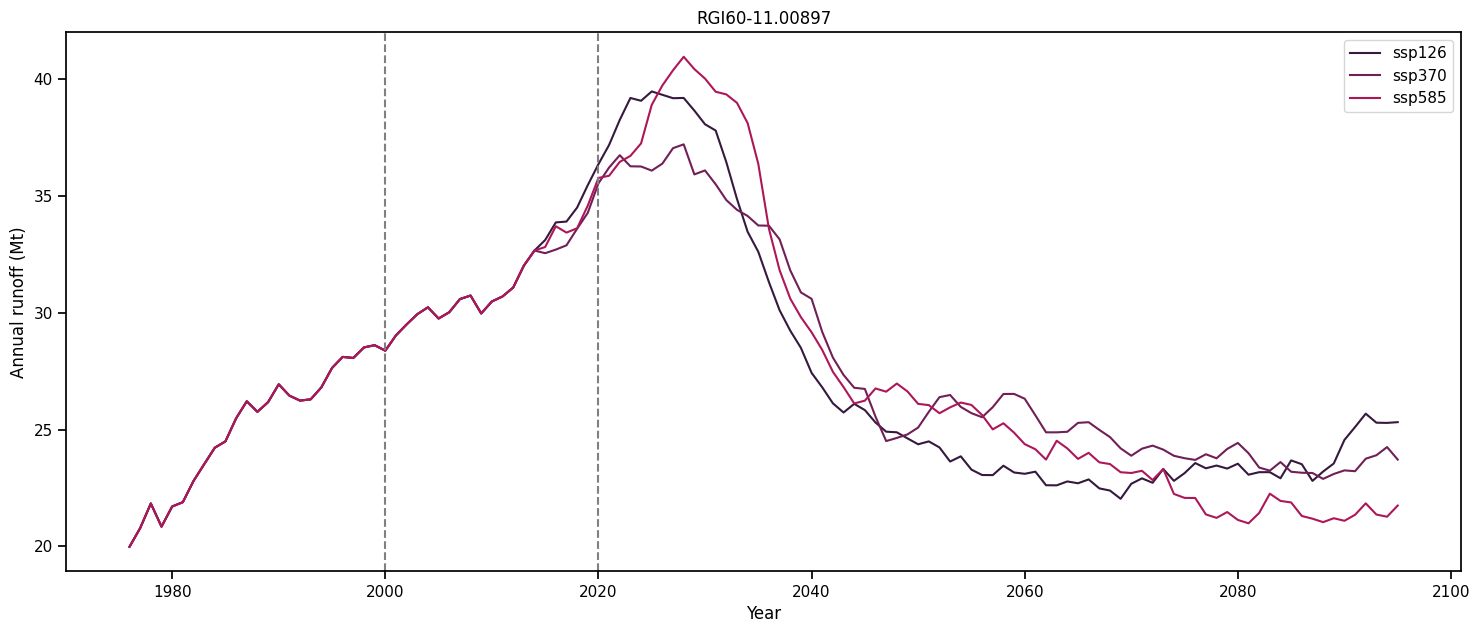

In [106]:
gdirs = [gdir]
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_merged_{member}_{ssp}'
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1).rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[0].rgi_id); plt.legend();
ax.axvline(2000, c='grey', ls='--')
ax.axvline(2020, c='grey', ls='--')

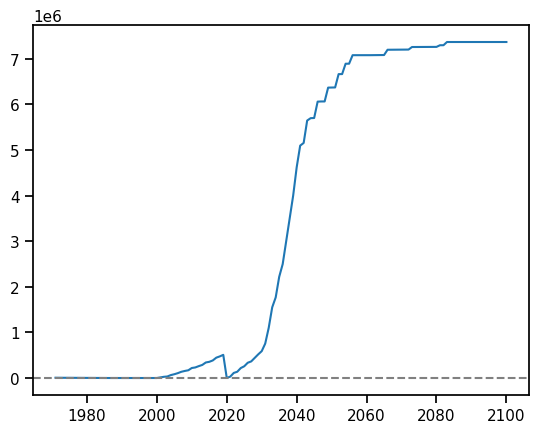

In [114]:
dt = xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix=f'_merged_{member}_{ssp}'))
dt = dt.mean(dim='month_2d')

plt.plot(dt.time, dt['off_area'] + dt['on_area'] - dt.area_m2)
plt.axhline(0, ls='--', color='grey')

In [76]:


with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_merged')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf = ds[sel_vars].to_dataframe().iloc[:-1]

# Domain area is constant and equal to the first year
odf['dom_area'] = odf['on_area'] + odf['off_area']

# Sanity checks
odf['tot_prcp'] = (odf['liq_prcp_off_glacier'] +
                   odf['liq_prcp_on_glacier'] +
                   odf['snowfall_off_glacier'] +
                   odf['snowfall_on_glacier'])

# Glacier area is the same (remove on_area?)
np.testing.assert_allclose(odf['on_area'], odf['area_m2'])

# Our MB is the same as the glacier dyn one
reconstructed_vol = (odf['model_mb'].cumsum() / oggm.cfg.PARAMS['ice_density'] +
                     odf['volume_m3'].iloc[0])
np.testing.assert_allclose(odf['volume_m3'].iloc[1:], reconstructed_vol.iloc[:-1])

# Ensure mass-conservation even at junction?
odf['runoff'] = (odf['melt_on_glacier'] +
                 odf['melt_off_glacier'] +
                 odf['liq_prcp_on_glacier'] +
                 odf['liq_prcp_off_glacier'])

mass_in_glacier_end = odf['volume_m3'].iloc[-1] * oggm.cfg.PARAMS['ice_density']
mass_in_glacier_start = odf['volume_m3'].iloc[0] * oggm.cfg.PARAMS['ice_density']

mass_in_snow = odf['snow_bucket'].iloc[-1]
mass_in = odf['tot_prcp'].iloc[:-1].sum()
mass_out = odf['runoff'].iloc[:-1].sum()
np.testing.assert_allclose(mass_in_glacier_end,
                mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                atol=1e-2)  # 0.01 kg is OK as numerical error

# Residual MB should not be crazy large
frac = odf['residual_mb'] / odf['melt_on_glacier']
np.testing.assert_allclose(frac, 0, atol=0.05)


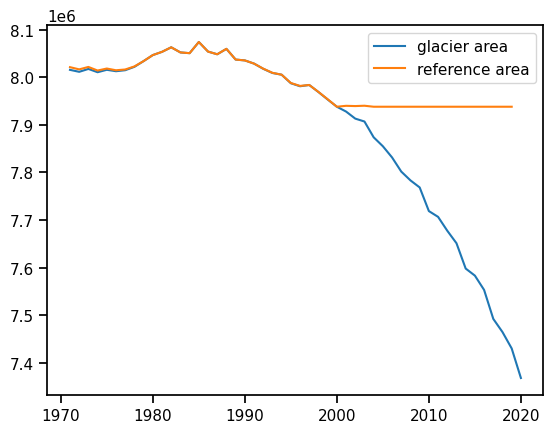

In [11]:
import shapely

In [12]:
shapely.__version__

'1.8.5.post1'

In [ ]:
gdir = workflow.init_glacier_directories(
            ['RGI60-11.00897'],  # Hintereisferner
            from_prepro_level=3, prepro_border=160,
            prepro_base_url='https://cluster.klima.uni-bremen.de/~oggm/gdirs/'
                            'oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/')[0]

        # Add debug vars
        cfg.PARAMS['store_diagnostic_variables'] = ALL_DIAGS
        # Needed for this to run
        cfg.PARAMS['store_model_geometry'] = True

        melt_f_max = 1000 * 12 / 365
        tasks.run_with_hydro(
            gdir, run_task=tasks.run_dynamic_melt_f_calibration,
            store_monthly_hydro=True, ref_area_from_y0=True,
            output_filesuffix='_dyn_melt_f_calib', melt_f_max=melt_f_max,
            run_function=dynamic_melt_f_run_with_dynamic_spinup,
            kwargs_run_function={'do_inversion': do_inversion},
            fallback_function=dynamic_melt_f_run_with_dynamic_spinup_fallback,
            kwargs_fallback_function={'do_inversion': do_inversion},)

        with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                               filesuffix='_dyn_melt_f_calib')) as ds:
            sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
            odf = ds[sel_vars].to_dataframe().iloc[:-1]

        # Domain area is constant and equal to the first year
        odf['dom_area'] = odf['on_area'] + odf['off_area']

        # Sanity checks
        odf['tot_prcp'] = (odf['liq_prcp_off_glacier'] +
                           odf['liq_prcp_on_glacier'] +
                           odf['snowfall_off_glacier'] +
                           odf['snowfall_on_glacier'])

        # Glacier area is the same (remove on_area?)
        assert_allclose(odf['on_area'], odf['area_m2'])

        # Our MB is the same as the glacier dyn one
        reconstructed_vol = (odf['model_mb'].cumsum() / cfg.PARAMS['ice_density'] +
                             odf['volume_m3'].iloc[0])
        assert_allclose(odf['volume_m3'].iloc[1:], reconstructed_vol.iloc[:-1])

        # Ensure mass-conservation even at junction?
        odf['runoff'] = (odf['melt_on_glacier'] +
                         odf['melt_off_glacier'] +
                         odf['liq_prcp_on_glacier'] +
                         odf['liq_prcp_off_glacier'])

        mass_in_glacier_end = odf['volume_m3'].iloc[-1] * cfg.PARAMS['ice_density']
        mass_in_glacier_start = odf['volume_m3'].iloc[0] * cfg.PARAMS['ice_density']

        mass_in_snow = odf['snow_bucket'].iloc[-1]
        mass_in = odf['tot_prcp'].iloc[:-1].sum()
        mass_out = odf['runoff'].iloc[:-1].sum()
        assert_allclose(mass_in_glacier_end,
                        mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                        atol=1e-2)  # 0.01 kg is OK as numerical error

        # Residual MB should not be crazy large
        frac = odf['residual_mb'] / odf['melt_on_glacier']
        assert_allclose(frac, 0, atol=0.05)
